Introduction:The growing field of web mapping, which involves processing data to create visual insights, empowers organizations to gain valuable geographic knowledge.  I'm particularly interested in exploring this potential for the City of Toronto, so I propose to enhance the City of Toronto Open Data Portal by incorporating new data files. These files would integrate information on Toronto's diverse cultural hotspots with municipal ward boundaries, providing a richer understanding of the city's cultural landscape.Merging cultural hotspot and municipal ward boundary data creates a powerful visualization tool. This map can showcase Toronto's unique attractions and highlight the correlation between cultural richness and administrative divisions, offering valuable insights for residents and visitors alike.(These datasets are chosen not just for their content, but also for the insights they offer when combined.)

In [1]:
%matplotlib inline
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import json
import requests
import folium
from folium.plugins import MarkerCluster
import io  
from shapely.geometry import MultiPolygon
import ast
import matplotlib.pyplot as pl


About the API that i used here is CKAN- API, from the open data source of the city of Toronto which is a powerful, RPC-style API that exposes all of CKAN’s core features to API clients. CKAN website’s core functionality is open source for the users. I requested and retrived data from the API about the cultural hotspots in the Toronto city. With that i converted the data files into data frames for the further implementation.

In [2]:
response = requests.get("https://ckan0.cf.opendata.inter.prod-toronto.ca")
response

<Response [200]>

In [3]:
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"
url = base_url + "/api/3/action/package_show"
params = { "id": "cultural-hotspot-points-of-interest"}
package_info = requests.get(url, params=params).json()

if package_info["success"]:
    resources = package_info["result"]["resources"]
    for resource in resources:
        if resource["datastore_active"]:
            resource_id = resource["id"]
            csv_url = f"{base_url}/datastore/dump/{resource_id}"
            csv_data = requests.get(csv_url).text
            df = pd.read_csv(io.StringIO(csv_data))
            display(df.head()) 
else:
    print("Package not found or no active resources available.")


_id LoopsGuide  Loop  TourNum  OrderNum                LoopTourName  \
0    1       York     2        2       7.0  The Future in Mount Dennis   
1    2       York     2        2       8.0  The Future in Mount Dennis   
2    3       York     2        2      12.0  The Future in Mount Dennis   
3    4       York     2        2      11.0  The Future in Mount Dennis   
4    5       York     2        2       9.0  The Future in Mount Dennis   

  LoopTourURL TourLabel                   SiteName Neighbourhood  ...  \
0         NaN       NaN   Up To This Moment (2019)  Mount Dennis  ...   
1         NaN       NaN            Untitled (2019)  Mount Dennis  ...   
2         NaN       NaN                John Dennis  Mount Dennis  ...   
3         NaN       NaN       Mount Dennis Library  Mount Dennis  ...   
4         NaN       NaN  Black Creek at Weston Rd.  Mount Dennis  ...   

  ImageCreditExternalLink                                       ImageAltText  \
0                     NaN                                                NaN   
1                     NaN                                                NaN   
2                     NaN                                                NaN   
3                     NaN  The two-story Mount Dennis Library featuring a...   
4                     NaN  A section of Black Creek running through a con...   

                                            ImageURL  \
0  https://contrib0.wp.intra.dev-toronto.ca/ext/e...   
1  https://contrib0.wp.intra.dev-toronto.ca/ext/e...   
2  https://contrib0.wp.intra.dev-toronto.ca/ext/e...   
3  https://contrib0.wp.intra.dev-toronto.ca/ext/e...   
4  https://contrib0.wp.intra.dev-toronto.ca/ext/e...   

                                            ThumbURL ImageOrientation test1  \
0  https://contrib0.wp.intra.dev-toronto.ca/ext/e...         Portrait   NaN   
1  https://contrib0.wp.intra.dev-toronto.ca/ext/e...         Portrait   NaN   
2  https://contrib0.wp.intra.dev-toronto.ca/ext/e...         Portrait   NaN   
3  https://contrib0.wp.intra.dev-toronto.ca/ext/e...        Landscape   NaN   
4  https://contrib0.wp.intra.dev-toronto.ca/ext/e...         Portrait   NaN   

  test2 test3 ObjectId                                           geometry  
0   NaN   NaN        1  {"type": "Point", "coordinates": [-79.48458, 4...  
1   NaN   NaN        2  {"type": "Point", "coordinates": [-79.48487, 4...  
2   NaN   NaN        3  {"type": "Point", "coordinates": [-79.48888, 4...  
3   NaN   NaN        4  {"type": "Point", "coordinates": [-79.48833, 4...  
4   NaN   NaN        5  {"type": "Point", "coordinates": [-79.48012, 4...  

[5 rows x 30 columns]

I've chosen specific data points from the available files to create a map. These points are essential for understanding the places we're exploring and will also be valuable for future updates that provide deeper insights. The chosen data includes details like site names, neighborhoods, types of entries, points of interest, descriptions, addresses, external links, and image descriptions – all the information needed to create a rich picture of these locations. I've also filterd some sections like 'Tour description,' 'Did you know?' repetitions, and 'Explore more' which are directly relevant to the idea of my map's core function.

In [4]:
columns_to_drop = ['Loop','_id','TourNum','OrderNum','LoopTourName', 
                   'LoopTourURL','TourLabel','ImageCredit', 'DirectionsCar','TourType','DirectionsTransit','LoopsGuide','Duration','ImageCreditExternalLink','ImageURL','ThumbURL','ImageOrientation','test1','test2','test3','ObjectId']
columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop, inplace=True)
print(df.columns)

Index(['SiteName', 'Neighbourhood', 'EntryType', 'Interests', 'Description',
       'Address', 'ExternalLink', 'ImageAltText', 'geometry'],
      dtype='object')


In [5]:
filtered_df = df[df['EntryType'].isin(['Tour description','Did you know?','Did you know','Explore more'])]
filtered_df.head()

SiteName Neighbourhood      EntryType  Interests  \
2                     John Dennis  Mount Dennis  Did you know?    History   
10             Trethewey Airfield  Mount Dennis   Explore more    History   
21  The Weston Historical Society        Weston  Did you know?    History   
22      Raymore Bridge and Plaque        Weston   Explore more    History   
23             Weston Village BIA        Weston  Did you know?  Community   

                                          Description  \
2   Mount Dennis is named for John Dennis, a shipb...   
10  The Trethewey Airfield was Toronto's first air...   
21  The Weston Historical Society, an affiliate to...   
22  The original bridge, along with many homes on ...   
23  The Weston Village BIA, established in 1979, i...   

                                              Address  \
2                        Weston Rd. and Eglinton Ave.   
10                                     59 Hearst Cir.   
21                            1901 Weston Rd., Unit F   
22  Raymore Park, entrance at Bellevue Cres. And H...   
23                                         4 John St.   

                                         ExternalLink  \
2                                                 NaN   
10                                                NaN   
21                                                NaN   
22  https://www.toronto.ca/data/parks/prd/faciliti...   
23                  https://www.westonvillagebia.com/   

                                         ImageAltText  \
2                                                 NaN   
10  A black line illustration of a domed Trethewey...   
21                                                NaN   
22                                                NaN   
23                                                NaN   

                                             geometry  
2   {"type": "Point", "coordinates": [-79.48888, 4...  
10  {"type": "Point", "coordinates": [-79.4997787,...  
21  {"type": "Point", "coordinates": [-79.51608, 4...  
22  {"type": "Point", "coordinates": [-79.514619, ...  
23  {"type": "Point", "coordinates": [-79.5177, 43...

In [6]:
def parse_geometry(geom_str):
    geom_dict = json.loads(geom_str)
    return Point(geom_dict['coordinates'][0], geom_dict['coordinates'][1])
geometry = filtered_df['geometry'].apply(parse_geometry)
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)
gdf

SiteName            Neighbourhood      EntryType  \
2                      John Dennis             Mount Dennis  Did you know?   
10              Trethewey Airfield             Mount Dennis   Explore more   
21   The Weston Historical Society                   Weston  Did you know?   
22       Raymore Bridge and Plaque                   Weston   Explore more   
23              Weston Village BIA                   Weston  Did you know?   
..                             ...                      ...            ...   
800                    Don Station                Riverside  Did you know?   
836         East End Boating Clubs  Ashbridges Bay, Beaches  Did you know?   
842                   Sakura Trees                  Beaches  Did you know?   
873                 Tulip Festival                   Mimico  Did you know?   
891                  501 Streetcar      Lake Shore Blvd. W.  Did you know?   

     Interests                                        Description  \
2      History  Mount Dennis is named for John Dennis, a shipb...   
10     History  The Trethewey Airfield was Toronto's first air...   
21     History  The Weston Historical Society, an affiliate to...   
22     History  The original bridge, along with many homes on ...   
23   Community  The Weston Village BIA, established in 1979, i...   
..         ...                                                ...   
800    History  In 1896, the Canadian Pacific Railway opened a...   
836    History  For decades the East End's shoreline communiti...   
842     Nature  In 2017, 20 Sakura, known as Cherry Blossom Tr...   
873  Community  In the spring and summer months, the Mimico Vi...   
891    History  With nearly 24 kilometres of track, the 501 Qu...   

                                               Address  \
2                         Weston Rd. and Eglinton Ave.   
10                                      59 Hearst Cir.   
21                             1901 Weston Rd., Unit F   
22   Raymore Park, entrance at Bellevue Cres. And H...   
23                                          4 John St.   
..                                                 ...   
800                         Queen St E. and King St E.   
836                  Unwin Ave. at Tommy Thompson Park   
842             Woodbine Park, 1675 Lakeshore Blvd. E.   
873                Royal York Rd., south of Evans Ave.   
891                           3850 Lake Shore Blvd. W.   

                                          ExternalLink  \
2                                                  NaN   
10                                                 NaN   
21                                                 NaN   
22   https://www.toronto.ca/data/parks/prd/faciliti...   
23                   https://www.westonvillagebia.com/   
..                                                 ...   
800                                                NaN   
836                                                NaN   
842                                                NaN   
873                    https://mimicotulipfestival.ca/   
891                                                NaN   

                                          ImageAltText  \
2                                                  NaN   
10   A black line illustration of a domed Trethewey...   
21                                                 NaN   
22                                                 NaN   
23                                                 NaN   
..                                                 ...   
800  A faded green bridge with the words, "This riv...   
836                                                NaN   
842  A close-up picture of the Sakura Cherry Blosso...   
873                                                NaN   
891  Illustration of a red and white streetcar read...   

                       geometry  
2    POINT (-79.48888 43.68686)  
10   POINT (-79.49978 43.69937)  
21   POINT (-79.51608 43.70052)  
22   POINT (-79.51462 43.69688)  

I have downloaded the data files from the Toronto city open data source and make a use of it by converting into the data frames and later changed that into geo data frame (gdf_new) for the use of plotting.

In [130]:
csv_file_url = "/Users/siddarthrathinam/Documents/Documents/ENVS456/labs/City Wards Data - 4326.csv"
df_new = pd.read_csv(csv_file_url)
df_new

_id  AREA_ID  DATE_EFFECTIVE  DATE_EXPIRY  AREA_ATTR_ID  AREA_TYPE_ID  \
0     1  2457740             NaN          NaN      25993196           528   
1     2  2457739             NaN          NaN      25993195           528   
2     3  2457738             NaN          NaN      25993194           528   
3     4  2457737             NaN          NaN      25993193           528   
4     5  2457736             NaN          NaN      25993192           528   
5     6  2457735             NaN          NaN      25993191           528   
6     7  2457734             NaN          NaN      25993190           528   
7     8  2457733             NaN          NaN      25993189           528   
8     9  2457732             NaN          NaN      25993188           528   
9    10  2457731             NaN          NaN      25993187           528   
10   11  2457730             NaN          NaN      25993186           528   
11   12  2457729             NaN          NaN      25993185           528   
12   13  2457728             NaN          NaN      25993184           528   
13   14  2457727             NaN          NaN      25993183           528   
14   15  2457726             NaN          NaN      25993182           528   
15   16  2457725             NaN          NaN      25993181           528   
16   17  2457724             NaN          NaN      25993180           528   
17   18  2457723             NaN          NaN      25993179           528   
18   19  2457722             NaN          NaN      25993178           528   
19   20  2457721             NaN          NaN      25993177           528   
20   21  2457720             NaN          NaN      25993176           528   
21   22  2457719             NaN          NaN      25993175           528   
22   23  2457718             NaN          NaN      25993174           528   
23   24  2457717             NaN          NaN      25993173           528   
24   25  2457716             NaN          NaN      25993172           528   

    PARENT_AREA_ID AREA_TYPE  AREA_CLASS_ID  AREA_CLASS  AREA_SHORT_CODE  \
0              NaN      CITW            NaN         NaN                7   
1              NaN      CITW            NaN         NaN                6   
2              NaN      CITW            NaN         NaN               18   
3              NaN      CITW            NaN         NaN               11   
4              NaN      CITW            NaN         NaN               19   
5              NaN      CITW            NaN         NaN               20   
6              NaN      CITW            NaN         NaN               25   
7              NaN      CITW            NaN         NaN               23   
8              NaN      CITW            NaN         NaN               24   
9              NaN      CITW            NaN         NaN               21   
10             NaN      CITW            NaN         NaN               22   
11             NaN      CITW            NaN         NaN               15   
12             NaN      CITW            NaN         NaN               12   
13             NaN      CITW            NaN         NaN                4   
14             NaN      CITW            NaN         NaN                1   
15             NaN      CITW            NaN         NaN                3   
16             NaN      CITW            NaN         NaN                2   
17             NaN      CITW            NaN         NaN                8   
18             NaN      CITW            NaN         NaN               17   
19             NaN      CITW            NaN         NaN               16   
20             NaN      CITW            NaN         NaN                9   
21             NaN      CITW            NaN         NaN               13   
22             NaN      CITW            NaN         NaN                5   
23             NaN      CITW            NaN         NaN               14   
24             NaN      CITW            NaN         NaN               10   

    AREA_LONG_CODE      

Quick Note;dropped few data frames which is irrerelvent to the proposal.

In [96]:

columns_to_drop = ['_id', 'AREA_ID', 'AREA_TYPE', 'AREA_CLASS', 'AREA_SHORT_CODE',
       'AREA_LONG_CODE', 'AREA_DESC', 'OBJECTID', 'DATE_EFFECTIVE', 'DATE_EXPIRY', 'AREA_ATTR_ID','AREA_TYPE_ID', 'PARENT_AREA_ID', 'AREA_CLASS_ID', 'FEATURE_CODE', 'FEATURE_CODE_DESC', 'TRANS_ID_CREATE', 'TRANS_ID_EXPIRE',]

df_new.drop(columns=columns_to_drop, inplace=True)

print(df_new.columns)


Index(['AREA_NAME', 'geometry'], dtype='object')


In [97]:
df_new['geometry'] = df_new['geometry'].apply(lambda x: ast.literal_eval(x)['coordinates'])
df_new['geometry'] = df_new['geometry'].apply(lambda x: MultiPolygon(x))
gdf_new = gpd.GeoDataFrame(df_new, geometry='geometry')
print(gdf_new.head())


                  AREA_NAME                                           geometry
0  Humber River-Black Creek  MULTIPOLYGON (((-79.49105 43.76350, -79.49008 ...
1               York Centre  MULTIPOLYGON (((-79.44043 43.76340, -79.43998 ...
2                Willowdale  MULTIPOLYGON (((-79.39449 43.76157, -79.39461 ...
3       University-Rosedale  MULTIPOLYGON (((-79.39004 43.69050, -79.39004 ...
4         Beaches-East York  MULTIPOLYGON (((-79.29864 43.71515, -79.29837 ...


Plotting Begis with this static map that shows the Toronto city wards, can be updated in the following. I used street style basic base map from the mapbox by function to the 'url' of map box. This style base is well alligned with my idea and very similar to the open source data files. I used specific crs for the better projection and following the static map and the base map the other ones shows my work of improvement in the designing.

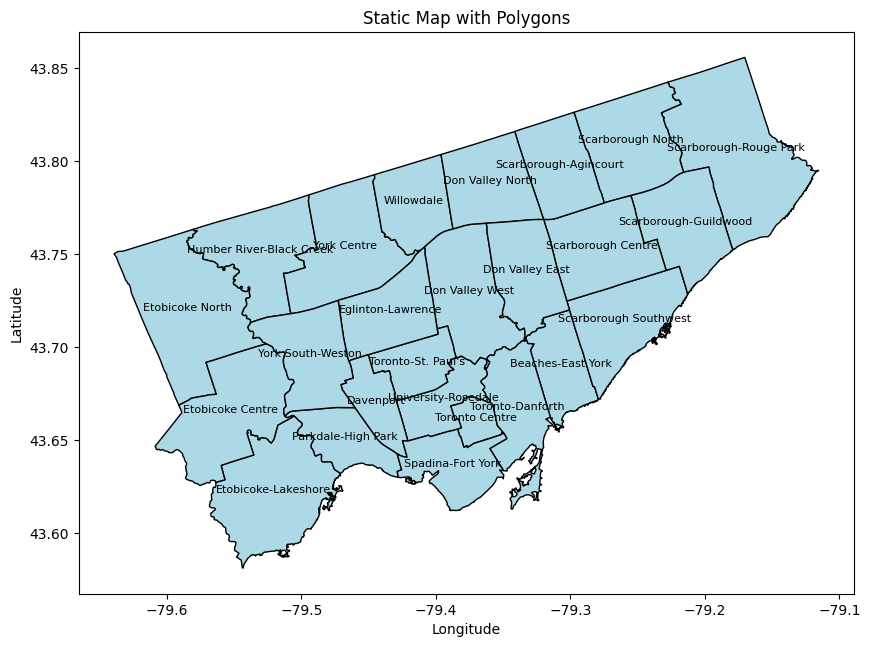

In [131]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_new.plot(ax=ax, color='lightblue', edgecolor='black', linewidth=1)
for idx, row in gdf_new.iterrows():
    ax.text(row.geometry.centroid.x, row.geometry.centroid.y, row['AREA_NAME'], fontsize=8, ha='center')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Static Map with Polygons')
plt.show()


In [115]:
mapbox_style_url = "https://api.mapbox.com/styles/v1/sgtkumar/clthmqjmw005j01pj3ujncc8p/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2d0a3VtYXIiLCJhIjoiY2xzdnFjMmpyMmQybjJqcHM2eHhyajlyZSJ9.aQrxL6j9uSGZseuBzaB8TQ"
m = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles=mapbox_style_url, attr="Mapbox", control_scale=True)
m.save("map.html")
m

In [120]:
gdf_new.crs = "EPSG:4326"  
mapbox_style_url = "https://api.mapbox.com/styles/v1/sgtkumar/clthmqjmw005j01pj3ujncc8p/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2d0a3VtYXIiLCJhIjoiY2xzdnFjMmpyMmQybjJqcHM2eHhyajlyZSJ9.aQrxL6j9uSGZseuBzaB8TQ"
m = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles=mapbox_style_url, attr="Mapbox", control_scale=True)
folium.GeoJson(gdf_new,
               name='geojson',
               style_function=lambda feature: {
                   'color': 'blue',
                   'fillColor': 'transparent',
                   'weight': 1
               },
              ).add_to(m)

for idx, row in gdf_new.iterrows():
    folium.Marker(location=[row.geometry.centroid.y, row.geometry.centroid.x], 
                  icon=folium.DivIcon(html=f'<div style="font-size: 10pt">{row["AREA_NAME"]}</div>')
                 ).add_to(m)
m


In [127]:
gdf_new.crs = "EPSG:4326"
mapbox_style_url = "https://api.mapbox.com/styles/v1/sgtkumar/clthmqjmw005j01pj3ujncc8p/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2d0a3VtYXIiLCJhIjoiY2xzdnFjMmpyMmQybjJqcHM2eHhyajlyZSJ9.aQrxL6j9uSGZseuBzaB8TQ"
m = folium.Map(location=[43.7, -79.4], zoom_start=8, tiles=mapbox_style_url, attr="Mapbox", control_scale=True)
folium.GeoJson(gdf_new,
               name='polygons',
               style_function=lambda feature: {
                   'color': 'blue',
                   'fillColor': 'transparent',
                   'weight': 1
               },
               tooltip=folium.features.GeoJsonTooltip(fields=['AREA_NAME']),
               popup=folium.features.GeoJsonPopup(fields=['AREA_NAME'])
              ).add_to(m)

folium.GeoJson(gdf_new,
                name='geojson',
                style_function=lambda feature: {
                    'color': 'black',
                    'fillColor': 'transparent',
                    'weight': 1
                },
                highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
                show=False  # Set show=False to hide the polygons initially
               ).add_to(m)

for idx, row in gdf.iterrows():
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=row['SiteName']).add_to(m)
m.save("static_map.html")
m


Final interactive map: Gives the better view of my proposel which is combinination of two data sets two show the cultural hotspots in the city of toronto with in the wards. along with the few creative idea's that i have learned during this work. which consists the clustering and hovering the Area Name of the polygons. Uesd popup width 400 for the better visiblity.

In [119]:
gdf_new.crs = "EPSG:4326"
mapbox_style_url = "https://api.mapbox.com/styles/v1/sgtkumar/clthmqjmw005j01pj3ujncc8p/tiles/{z}/{x}/{y}?access_token=pk.eyJ1Ijoic2d0a3VtYXIiLCJhIjoiY2xzdnFjMmpyMmQybjJqcHM2eHhyajlyZSJ9.aQrxL6j9uSGZseuBzaB8TQ"
m = folium.Map(location=[43.7, -79.4], zoom_start=11, tiles=mapbox_style_url, attr="Mapbox", control_scale=True)
marker_cluster = MarkerCluster().add_to(m)
folium.GeoJson(gdf_new,
               name='polygons',
               style_function=lambda feature: {
                   'color': 'blue',
                   'fillColor': 'transparent',
                   'weight': 1
               },
               tooltip=folium.features.GeoJsonTooltip(fields=['AREA_NAME']),
              ).add_to(m)

folium.GeoJson(gdf_new,
                name='geojson',
                style_function=lambda feature: {
                    'color': 'black',
                    'fillColor': 'transparent',
                    'weight': 1
                },
                highlight_function=lambda x: {'weight': 3, 'color': 'blue'},
                show=False  
               ).add_to(m)

for idx, row in gdf.iterrows():
    popup_content = ''
    for col_name in ['SiteName', 'Neighbourhood', 'EntryType', 'Interests', 'Description',
                     'Address', 'ExternalLink', 'ImageAltText', 'geometry']:
        popup_content += f"<b>{col_name}:</b> {row[col_name]}<br>"
    popup = folium.Popup(popup_content, max_width=400)
    folium.Marker(location=[row.geometry.y, row.geometry.x], popup=popup).add_to(marker_cluster)

m.save("map_with_points_and_polygons.html")
m


Conclusion:The result of this map won't just be a valuable tool for navigating Toronto's cultural scene but also an empowering resource for organisations and policymakers. It can inform decisions related to cultural development and urban planning initiatives. Ultimately, every element on the map serves a specific purpose: to illuminate the connection between culture and governance in Toronto, and to foster a deeper understanding of its diverse communities and attractions.